<a href="https://colab.research.google.com/github/uninstallit/ati580_final_project/blob/edvin-1/ati580_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning portion of ATI580 Final Project**

In [ ]:
pip install dnspython

In [ ]:
pip install --upgrade tf-nightly

In [1]:
from pymongo import MongoClient

class Connect(object):

  @staticmethod    
  def get_connection(database):
    username = "mdbUser"
    password = "ati580"
    return MongoClient('mongodb+srv://{}:{}@ati580-cluster.s5t5z.gcp.mongodb.net/{}?retryWrites=true&w=majority'.format(username, password, database))

In [ ]:
# # save
# from google.colab import drive
# drive.mount('/content/gdrive')
# pip freeze --local > /content/gdrive/My\ Drive/colab_installed.txt

# # restore
# from google.colab import drive
# drive.mount('/content/gdrive')
# pip install --upgrade --force-reinstall `cat/content/gdrive/My\ Drive/colab_installed.txt`

In [ ]:
#plotly: https://plotly.com/python/ipython-notebook-tutorial/

In [4]:
import pandas as pd
import numpy as np
import pymongo
import datetime

class Preprocess(object):

  def __init__(self):
    # select columns
    self._columns = dict({
        'FieldInterviewID':0,     
        'NOPD_Item':0,            
        'EventDate':1,            
        'District':1,             
        'Zone':1,                 
        'OfficerAssignment':0, 
        'StopDescription':1, 
        'ActionsTaken':0, 
        'VehicleYear':1, 
        'VehicleMake':1, 
        'VehicleModel':1, 
        'VehicleStyle':1, 
        'VehicleColor':1, 
        'SubjectID':0, 
        'SubjectRace':1, 
        'SubjectGender':1, 
        'SubjectAge':1, 
        'SubjectHasPhotoID':0, 
        'SubjectHeight':1, 
        'SubjectWeight':1, 
        'SubjectEyeColor':0, 
        'SubjectHairColor':1, 
        'SubjectDriverLicState':1, 
        'CreatedDateTime':0, 
        'LastModifiedDateTime':0, 
        'Longitude':0, 
        'Latitude':0, 
        'Zip':1, 
        'BlockAddress':0})

    # connect to database
    self._connect = Connect()
    self._mdb_client = self._connect.get_connection("POLICE_DATABASE")
    self._mdb_database = self._mdb_client['POLICE_DATABASE'] 
    self._mdb_collection = self._mdb_database['POLICE_INTERVIEWS']

  # convert queries to dataframe or numpy array
  def query_and_convert(self, filter, projection, to="dataframe", rows=None):
    if rows is not None:
      _cursor = self._mdb_collection.find(filter, projection).limit(rows)
    else:
      _cursor = self._mdb_collection.find(filter, projection)
    _dataframe = pd.DataFrame(list(_cursor))
    if to is "dataframe":
      return _dataframe
    elif to is "numpy":
      _np_array = np.transpose(np.squeeze(_dataframe.to_numpy()))
      return _np_array
  
  # convert time to seconds 
  @staticmethod
  def time_to_int_seconds(datetime_str):
    time = datetime.datetime.strptime(datetime_str, '%m/%d/%Y %H:%M:%S %p').time()
    [hours, minutes, seconds] = [int(t) for t in str(time).split(':')]
    return datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds).seconds

  # convert license tag to binary
  @staticmethod
  def instate_or_outofstate(license):
    if license is "LA":
      return 1
    return 0

  # convert stop description to binary
  @staticmethod
  def cause_or_suspicion(description):
    _probable_cause_list = ["CRIMINAL VIOLATION", "JUVENILE VIOLATION", "TRAFFIC VIOLATION"]
    if description in _probable_cause_list:
      return 0
    return "1"

  def get_feature_dataframe(self, rows):
    _filter = []
    _projection = dict({'_id':0})
    # create filter
    for key, value in self._columns.items():
      if value is 1:
        _filter.append({key:{"$exists": True}})
        _filter.append({key:{"$ne": ""}})
        _filter.append({key:{"$ne": None}})
        _filter.append({key:{"$ne": 0}})
    # create projection
    for key, value in self._columns.items():
      if value is 1:
        _projection[key] = value
    # query database
    _colum_query_df = self.query_and_convert({"$and":_filter}, _projection, rows=rows)
    print(_colum_query_df["StopDescription"])
    # convert specific columns
    _colum_query_df['EventDate'] = _colum_query_df['EventDate'].apply(lambda x: self.time_to_int_seconds(x))
    _colum_query_df['SubjectDriverLicState'] = _colum_query_df['SubjectDriverLicState'].apply(lambda x: self.instate_or_outofstate(x))
    _colum_query_df['StopDescription'] = _colum_query_df['StopDescription'].apply(lambda x: self.cause_or_suspicion(x))
    return _colum_query_df


In [5]:
preprocess = Preprocess()
police_features_df = preprocess.get_feature_dataframe(rows=5)
print(police_features_df)

0    TRAFFIC VIOLATION
1    TRAFFIC VIOLATION
2    TRAFFIC VIOLATION
3    TRAFFIC VIOLATION
4    TRAFFIC VIOLATION
Name: StopDescription, dtype: object
   EventDate  District Zone  ...  SubjectHairColor  SubjectDriverLicState      Zip
0      34500         7    O  ...             Black                      0  70127.0
1      38160         7    D  ...             Black                      0  70126.0
2      43740         7    O  ...             Black                      0  70118.0
3      32580         7    C  ...             Black                      0  70126.0
4      32580         7    C  ...             Black                      0  70126.0

[5 rows x 17 columns]


## **Structured data classification**
- Data includes both numerical and categorical features. 
- Use Keras preprocessing layers to normalize the numerical features and vectorize the categorical ones.
- Source: [Keras | Code examples](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)
- CategoricalEncoding API: [Tensorflow](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/experimental/preprocessing/CategoryEncoding#methods)

## **Column Description**
- SubjectGender   (Categorical)
- SubjectAge.     (Numerical)
- StopDescription (Categorical)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

# prepare the data 
cursor = mdb_collection.find({
    "$and":[{"SubjectGender":{"$exists": True}}, 
            {"SubjectGender":{"$ne": ""}},
            {"SubjectGender":{"$ne": None}},
            {"SubjectAge":{"$exists": True}}, 
            {"SubjectAge":{"$ne": ""}},
            {"SubjectAge":{"$ne": None}},
            {"StopDescription":{"$exists": True}}, 
            {"StopDescription":{"$ne": ""}},
            {"StopDescription":{"$ne": None}} ]}, 
            { "_id":0, "SubjectGender" : 1 , "SubjectAge" : 1 , "StopDescription" : 1})

subject_df = pd.DataFrame(list(cursor))
print("subject dataframe shape: {} \n".format(subject_df.shape))
print(subject_df.head())

reasonable_suspicion = {"CALL FOR SERVICE":1,
                        "CITIZEN CONTACT":1,
                        "FLAGGED DOWN":1,
                        "OTHER":1,
                        "PRESENT AT CRIME SCENE":1,
                        "SUSPECT PERSON":1,
                        "SUSPECT VEHICLE":1}

probable_cause_list = {"CRIMINAL VIOLATION":0, 
                       "JUVENILE VIOLATION":0, 
                       "TRAFFIC VIOLATION":0}

subject_df["StopDescription"] = subject_df["StopDescription"].replace(reasonable_suspicion)
subject_df["StopDescription"] = subject_df["StopDescription"].replace(probable_cause_list)

print(subject_df.head())

# split the data into a training and validation set
eval_subject_df  = subject_df.sample(frac=0.2, random_state=1337)
train_subject_df = subject_df.drop(eval_subject_df.index)
print("Using %d samples for training and %d for validation" % (len(train_subject_df), len(eval_subject_df)))

# convert dataframe_to_dataset 
def dataframe_to_dataset(dataframe, output_name):
    _dataframe = dataframe.copy()
    _labels    = _dataframe.pop(output_name)
    _dataset   = tf.data.Dataset.from_tensor_slices((dict(_dataframe), _labels))
    _dataset   = _dataset.shuffle(buffer_size=len(_dataframe))
    return _dataset

train_subject_ds = dataframe_to_dataset(train_subject_df, "StopDescription")
eval_subject_ds  = dataframe_to_dataset(eval_subject_df, "StopDescription")

train_subject_ds = train_subject_ds.batch(32)
eval_subject_ds  = eval_subject_ds.batch(32)

print("dataset preparation done")

subject dataframe shape: (576132, 3) 

     StopDescription SubjectGender  SubjectAge
0  TRAFFIC VIOLATION        FEMALE        26.0
1   CALL FOR SERVICE          MALE        17.0
2   CALL FOR SERVICE          MALE        18.0
3   CALL FOR SERVICE          MALE        18.0
4   CALL FOR SERVICE          MALE        30.0
   StopDescription SubjectGender  SubjectAge
0                0        FEMALE        26.0
1                1          MALE        17.0
2                1          MALE        18.0
3                1          MALE        18.0
4                1          MALE        30.0
Using 460906 samples for training and 115226 for validation
dataset preparation done


## **one-hot Encoding of features**

In [1]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    # Learn the statistics of the data
    normalizer.adapt(feature_ds)
    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)
    # Turn the string input into integer indices
    encoded_feature = index(feature)
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")
    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)
    # Learn the space of possible indices
    encoder.adapt(feature_ds)
    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature

def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    # Learn the space of possible indices
    encoder.adapt(feature_ds)
    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature

## **Build the model**

In [ ]:
# Categorical features encoded as integers
# stop_description = keras.Input(shape=(1,), name="StopDescription", dtype="int64")

# Categorical feature encoded as string
subject_gender = keras.Input(shape=(1,), name="SubjectGender", dtype="string")

# Numerical features
subject_age = keras.Input(shape=(1,), name="SubjectAge")

all_inputs = [subject_gender, subject_age]

# Integer categorical features
# no fields

# String categorical features
subject_gender_encoded = encode_string_categorical_feature(subject_gender, "SubjectGender", train_subject_ds)

# Numerical features
subject_age_encoded = encode_numerical_feature(subject_age, "SubjectAge", train_subject_ds)

all_features = layers.concatenate([subject_gender_encoded, subject_age_encoded])

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation="sigmoid")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(8, activation="sigmoid")(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

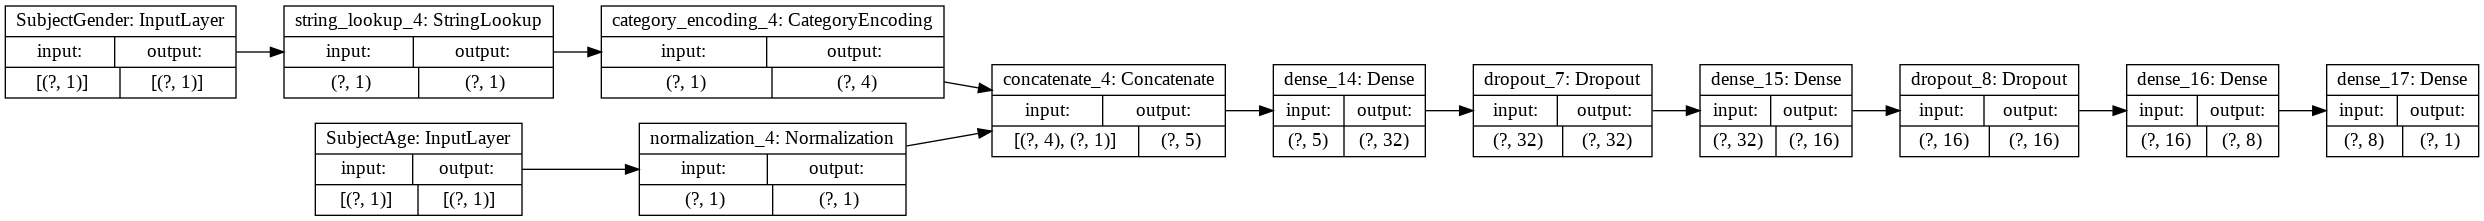

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.fit(train_subject_ds, epochs=5, validation_data=eval_subject_ds)

Epoch 1/5
14404/14404 [==============================] - 30s 2ms/step - loss: 0.6418 - accuracy: 0.6483 - val_loss: 0.6378 - val_accuracy: 0.6542
Epoch 2/5
14404/14404 [==============================] - 35s 2ms/step - loss: 0.6385 - accuracy: 0.6528 - val_loss: 0.6377 - val_accuracy: 0.6525
Epoch 3/5
14404/14404 [==============================] - 32s 2ms/step - loss: 0.6381 - accuracy: 0.6531 - val_loss: 0.6373 - val_accuracy: 0.6551
Epoch 4/5
14404/14404 [==============================] - 31s 2ms/step - loss: 0.6379 - accuracy: 0.6534 - val_loss: 0.6374 - val_accuracy: 0.6550
Epoch 5/5
14404/14404 [==============================] - 29s 2ms/step - loss: 0.6378 - accuracy: 0.6535 - val_loss: 0.6374 - val_accuracy: 0.6551


## **Infer from the model**

In [ ]:
sample = {
    "SubjectGender": "-9999999",
    "SubjectAge": -999999
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
tf.print(input_dict)
model.predict(input_dict)

{'SubjectAge': [-999999], 'SubjectGender': ["-9999999"]}


array([[0.65062386]], dtype=float32)

## **Logistic Regression with Tensorflow**

Binary Logistic Regression, in which the target variable has only two possible values, e.g., pass/fail or win/lose.

In [48]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

x, y = load_iris(return_X_y=True)

columns = dict({'FieldInterviewID':0,     
                'NOPD_Item':0, 
                'EventDate':0, 
                'District':0, 
                'Zone':0, 
                'OfficerAssignment':0, 
                'StopDescription':0, 
                'ActionsTaken':0, 
                'VehicleYear':1, 
                'VehicleMake':0, 
                'VehicleModel':0, 
                'VehicleStyle':0, 
                'VehicleColor':1, 
                'SubjectID':0, 
                'SubjectRace':1, 
                'SubjectGender':1, 
                'SubjectAge':0, 
                'SubjectHasPhotoID':0, 
                'SubjectHeight':1, 
                'SubjectWeight':0, 
                'SubjectEyeColor':0, 
                'SubjectHairColor':1, 
                'SubjectDriverLicState':0, 
                'CreatedDateTime':0, 
                'LastModifiedDateTime':0, 
                'Longitude':0, 
                'Latitude':0, 
                'Zip':1, 
                'BlockAddress':0})

print(x[:100])
print(y[:100])

clf = LogisticRegression(random_state=0).fit(X, y)

clf.predict(X[:2, :])
array([0, 0])

clf.predict_proba(X[:2, :])
array([[9.8...e-01, 1.8...e-02, 1.4...e-08],
       [9.7...e-01, 2.8...e-02, ...e-08]])
clf.score(X, y)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.